In [1]:
import pandas as pd
import numpy as np

### Load the data

In [2]:
dataset = pd.read_csv('./dataset/cleaned_dataset.csv')
print(dataset.shape)
print(dataset.head(10))
print(dataset.describe())

(20620, 2)
   label                                              tweet
0      1   rt  boy dats coldtyga dwn bad for cuffin dat ...
1      1   rt  dawg rt  you ever fuck a bitch and she st...
2      1          rt ganderson based she look like a tranny
3      1   rt  the shit you hear about me might be true ...
4      1  madisonx the shit just blows meclaim you so fa...
5      1  brighterdays i can not just sit up and hate on...
6      1  8220 cause im tired of you big bitches coming ...
7      1   amp you might not get ya bitch back amp thats...
8      1               hobbies include fighting mariambitch
9      1   keeks is a bitch she curves everyone  lol i w...
              label
count  20620.000000
mean       0.930650
std        0.254055
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        1.000000


In [3]:
from sklearn.model_selection import train_test_split

X = dataset['tweet']  # Input features
y = dataset['label']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print("Training set shape: ", X_train.shape, "\nLabel distribution: \n", y_train.value_counts())
print("\nTesting set shape: ", X_test.shape, "\nLabel distribution: \n", y_test.value_counts())

Training set shape:  (15465,) 
Label distribution: 
 label
1    14358
0     1107
Name: count, dtype: int64

Testing set shape:  (5155,) 
Label distribution: 
 label
1    4832
0     323
Name: count, dtype: int64


### Feature engineering and imbalanced data handling

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply TF-IDF vectorization to convert text data into numerical features
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [5]:
# Deal with imbalanced data

# Apply informed undersampling only to the training set
# ENN: Removes majority class examples that differ from their neighbors.
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_train_resampled, y_train_resampled = enn.fit_resample(X_train_tfidf, y_train)

# Tomek Links: Identifies pairs of very close instances, but of opposite classes, and removes the majority class instances from the pair.
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()
X_train_resampled, y_train_resampled = tl.fit_resample(X_train_tfidf, y_train)

# Repeated Edited Nearest Neighbours (RENN): Iterates ENN multiple times to further edit the dataset
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours()
X_train_resampled, y_train_resampled = renn.fit_resample(X_train_tfidf, y_train)

# Apply oversampling to the training set
# SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples by interpolating between existing minority instances.
from imblearn.over_sampling import SMOTE
smote = SMOTE()
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_tfidf, y_train)

# Apply Hybrid Methods
# SMOTEENN: Combines SMOTE and ENN.
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN()
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train_tfidf, y_train)

# SMOTETomek: Combines SMOTE and Tomek Links.
from imblearn.combine import SMOTETomek
smotetomek = SMOTETomek()
X_train_resampled, y_train_resampled = smotetomek.fit_resample(X_train_tfidf, y_train)


print("After undersampling:\n")
print("Training set shape: ", X_train_resampled.shape)
print("Label distribution:\n", pd.Series(y_train_resampled).value_counts())

After undersampling:

Training set shape:  (13518, 18863)
Label distribution:
 label
1    12411
0     1107
Name: count, dtype: int64


### Model Training

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

# Train Logistic Regression model with L1 regularization
logistic_regression_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000)  # Adjust max_iter as needed
logistic_regression_model.fit(X_train_resampled, y_train_resampled)

# Train Random Forest model
random_forest_model = RandomForestClassifier(n_estimators=100, random_state=42)  # You can adjust n_estimators as needed
random_forest_model.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(random_state=42)

### Model Evaluation

Logistic Regression
                    precision    recall  f1-score   support

       Hate Speech       0.44      0.40      0.42       323
Offensive Language       0.96      0.97      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.70      0.68      0.69      5155
      weighted avg       0.93      0.93      0.93      5155



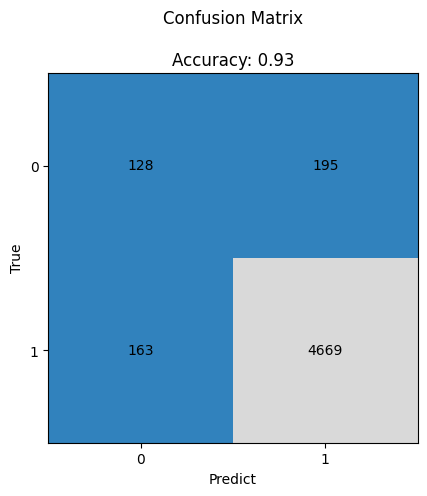

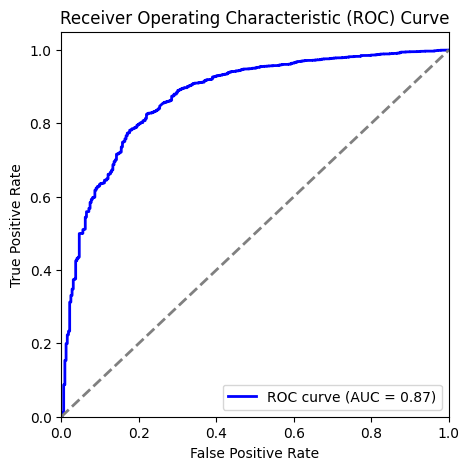

Random Forest
                    precision    recall  f1-score   support

       Hate Speech       0.45      0.45      0.45       323
Offensive Language       0.96      0.96      0.96      4832

          accuracy                           0.93      5155
         macro avg       0.71      0.70      0.71      5155
      weighted avg       0.93      0.93      0.93      5155



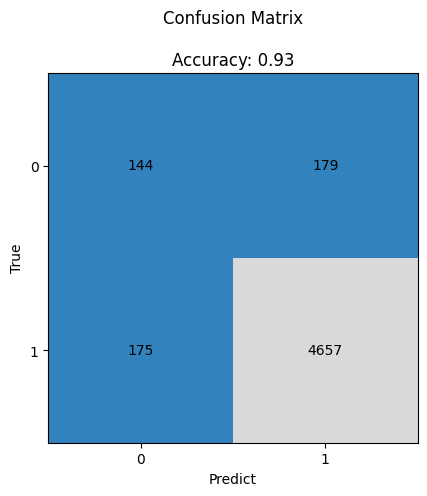

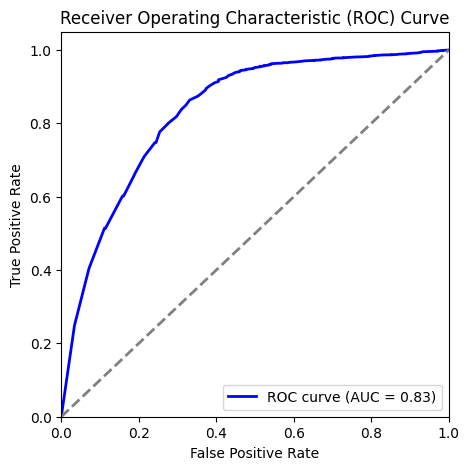

In [11]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming binary classification for simplicity; if multiclass, you'll need to adjust.
# Binary label indicators for ROC-AUC calculation if you have more than two classes
# y_test_binarized = label_binarize(y_test, classes

models = [logistic_regression_model, random_forest_model]
model_names = ['Logistic Regression', 'Random Forest']

for i, model in enumerate(models):
    y_predict = model.predict(X_test_tfidf)
    
    # Evaluate models by the classification report
    print(model_names[i])
    print(classification_report(y_test, y_predict, target_names=['Hate Speech', 'Offensive Language']))

    # Evaluate models by the confusion matrix
    grid = confusion_matrix(y_test, y_predict)
    accuracy = accuracy_score(y_test, y_predict)
 
    # Create a confusion matrix plot
    fig, ax = plt.subplots()

    # Plot the confusion matrix
    for (j, i), label in np.ndenumerate(grid):
        ax.text(i, j, label, ha='center', va='center')

    ax.set_title(f'Confusion Matrix\n\nAccuracy: {accuracy:.2f}')
    ax.imshow(grid, cmap='tab20c')
    ax.set_xticks([1, 0])
    ax.set_yticks([1, 0])
    ax.set_xlabel('Predict')
    ax.set_ylabel('True')

    # Create a ROC-AUC curve plot with score
    y_predict_proba = model.predict_proba(X_test_tfidf)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)
    roc_auc = roc_auc_score(y_test, y_predict_proba)
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()




### Imbalance method comparision

Metrics: logistic regression, f1 score, hate speech

Undersampling

- ENN: Removes majority class examples that differ from their neighbors.
  - 0.42
Training set shape:  (13518, 18863)
Label distribution:
 label
1    12411
0     1107

- Tomek Links: Identifies pairs of very close instances, but of opposite classes, and removes the majority class instances from the pair.
  - 0.32
Training set shape:  (15309, 18863)
Label distribution:
 label
1    14202
0     1107

- Repeated Edited Nearest Neighbours (RENN): Iterates ENN multiple times to further edit the dataset.
  - 0.43
Training set shape:  (12956, 18863)
Label distribution:
 label
1    11849
0     1107

Oversampling

- SMOTE (Synthetic Minority Over-sampling Technique): Generates synthetic samples by interpolating between existing minority instances.
  - 0.41
Training set shape:  (28716, 18863)
Label distribution:
 label
1    14358
0    14358



Hybrid Methods

- SMOTEENN: Combines SMOTE and ENN.
  - 0.20
Training set shape:  (16433, 18863)
Label distribution:
 label
0    14198
1     2235
Name: count, dtype: int64

- SMOTETomek: Combines SMOTE and Tomek Links.
  - 0.40
Training set shape:  (28716, 18863)
Label distribution:
 label
1    14358
0    14358
Name: count, dtype: int64




